# Quantum Convolutional Neural Network (QCNN)

Reference:
1. https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from compose_mnist_dataset import ComposeMnistDataset


In [ ]:
class ComposeConvNN:
    def conv_circuit(self, params):
        target = QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)
        target.cx(1, 0)
        target.rz(np.pi / 2, 0)
        return target

    def conv_layer(self, num_qubits, param_prefix):
        qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
        qubits = list(range(num_qubits))
        param_index = 0
        params = ParameterVector(param_prefix, length=num_qubits * 3)
        for q1, q2 in zip(qubits[0::2], qubits[1::2]):
            qc = qc.compose(self.conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
            qc.barrier()
            param_index += 3
        for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
            qc = qc.compose(self.conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = QuantumCircuit(num_qubits)
        qc.append(qc_inst, qubits)
        return qc

    def pool_circuit(self, params):
        target = QuantumCircuit(2)
        target.rz(-np.pi / 2, 1)
        target.cx(1, 0)
        target.rz(params[0], 0)
        target.ry(params[1], 1)
        target.cx(0, 1)
        target.ry(params[2], 1)

        return target

    def pool_layer(self, sources, sinks, param_prefix):
        num_qubits = len(sources) + len(sinks)
        qc = QuantumCircuit(num_qubits, name="Pooling Layer")
        param_index = 0
        params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
        for source, sink in zip(sources, sinks):
            qc = qc.compose(self.pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
            qc.barrier()
            param_index += 3

        qc_inst = qc.to_instruction()

        qc = QuantumCircuit(num_qubits)
        qc.append(qc_inst, range(num_qubits))
        return qc

    def compose_one_qcnn(self, num_qubits, conv_param_prefix, sources, sinks, pool_param_prefix):
        ansatz = QuantumCircuit(num_qubits)
        ansatz.compose(self.conv_layer(num_qubits, conv_param_prefix), inplace=True)
        ansatz.compose(self.pool_layer(sources, sinks, pool_param_prefix))

        return ansatz


In [ ]:
circuit = QuantumCircuit(16)
feature_map = ZFeatureMap(16, name="Featuremap")
ansatz = QuantumCircuit(16, name="Ansatz")
ansatz.compose(ComposeConvNN().compose_one_qcnn(16, "c1", [0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], "p1"), list(range(16)), inplace=True)
ansatz.compose(ComposeConvNN().compose_one_qcnn(8, "c2", [0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(8, 16)), inplace=True)
ansatz.compose(ComposeConvNN().compose_one_qcnn(4, "c3", [0, 1], [2, 3], "p3"), list(range(12, 16)), inplace=True)
ansatz.compose(ComposeConvNN().compose_one_qcnn(2, "c4", [0], [1], "p4"), list(range(14, 16)), inplace=True)
circuit.compose(feature_map, inplace=True)
circuit.compose(ansatz, inplace=True)
# circuit.decompose().draw("mpl", style="clifford")
# circuit.draw("mpl", style="clifford")

In [ ]:
observable = SparsePauliOp.from_list([("Z" + "I" * 15, 1)])

backend = AerSimulator()

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(layout=isa_circuit.layout)

estimator = Estimator()

qnn = EstimatorQNN(
    circuit = isa_circuit.decompose(),
    observables = isa_observable,
    input_params = feature_map.parameters,
    weight_params = ansatz.parameters,
    estimator=estimator
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [8]:
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# init randomly
initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer = COBYLA(maxiter=200),
    callback = callback_graph,
    initial_point = initial_point,
)

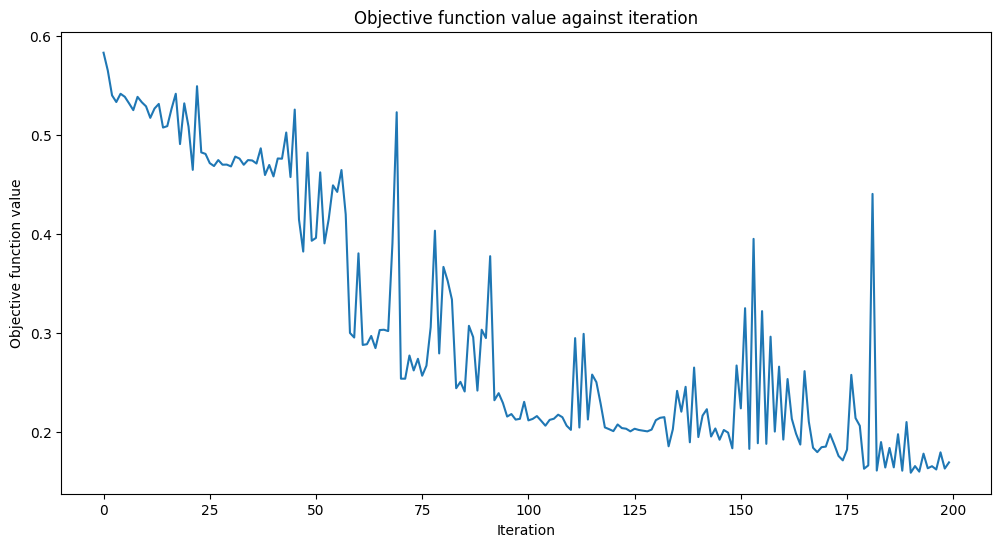

Accuracy from the train data: 56.25%


In [10]:
dataset = ComposeMnistDataset(None, None, 32, 32, 0, True)
train_loader, test_loader = dataset.exec(filter=[0, 1], size=(4, 4))

train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

train_images = train_images.flatten(start_dim=1)
test_images = test_images.flatten(start_dim=1)

x = np.asarray(train_images)
y = np.asarray(train_labels)

plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

print(f"Accuracy from the train data: {np.round(100 * classifier.score(x, y), 2)}%")

In [11]:
y_predict = classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data: {np.round(100 * classifier.score(x, y), 2)}%")


Accuracy from the test data: 53.12%
